<a href="https://colab.research.google.com/github/SamarSaeed1146/Internet_Chatbot/blob/main/internet_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr
# %pip install -U langgraph langsmith langchain_google_genai tavily-python langchain_community langchain_anthropic

In [42]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai tavily-python langchain_community langchain_anthropic

import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, BaseMessage, AIMessage, ToolMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from pydantic import BaseModel
from typing import Annotated
from typing_extensions import TypedDict
from graphviz import Digraph
from IPython.display import Image, display
from langchain.tools import BaseTool # Import BaseTool

# Set up API keys
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "internet_chatbot"
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

gemini_api_key = userdata.get('GEMINI_API_KEY')

# Define the chatbot model
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)
from typing import ClassVar # Import ClassVar

class InternetTool(BaseTool):
    name: ClassVar[str] = "internet_diagnostic_tool"  # Added type annotation with ClassVar
    description: ClassVar[str] = "A tool to diagnose internet problems."



    def _run(self, query: str) -> str:
        if "slow internet" in query.lower():
            return "The issue might be due to network congestion or ISP throttling. Try restarting your router."
        elif "no connection" in query.lower():
            return "Check your cables and ensure your router is powered on."
        elif "wifi not working" in query.lower():
            return "Reconnect to the WiFi or reset the network settings on your device."
        return "I'm unable to diagnose the issue. Please contact your ISP."

    async def _arun(self, query: str) -> str:
        """Use the tool asynchronously."""
        raise NotImplementedError("InternetTool does not support async")

# Tools integration
tool = TavilySearchResults(max_results=2)
custom_tool = InternetTool() # Instantiate InternetTool
tools = [tool, custom_tool]

# Define the chatbot state structure
class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool

class RequestAssistance(BaseModel):
    request: str

# Remove MockLLM and use the actual llm with bind_tools
def chatbot(state: State):
    response = llm.bind_tools(tools).invoke(state["messages"]) # Bind tools to llm
    ask_human = False
    if response.tool_calls and response.tool_calls[0]["name"] == RequestAssistance.__name__:
        ask_human = True
    return {"messages": state["messages"] + [response], "ask_human": ask_human}

# Rest of the code remains the same...
# Human escalation node
def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        new_messages.append(
            ToolMessage(content="No response from human.", tool_call_id=None)
        )
    return {
        "messages": state["messages"] + new_messages,
        "ask_human": False,
    }

# Define the state graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("human", human_node)

def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    return tools_condition(state)

graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "__end__": "__end__"},
)
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")

# Compile the graph
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)


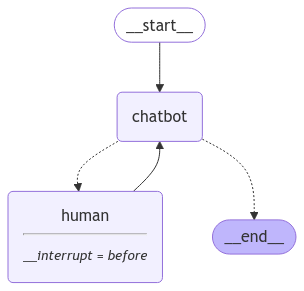

In [43]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [48]:
user_input = "my internet is not working"
config = {"configurable": {"thread_id": "1"}}
# Changed to initialize with HumanMessage
events = graph.stream(
    {"messages": [HumanMessage(content=user_input)]}, config, stream_mode="values"
)

# Display chatbot responses
for event in events:
    if "messages" in event:
        print(event["messages"][-1].content)

my internet is not working
Let's troubleshoot your internet connection. To help me understand the problem, please tell me:

* **What is the problem specifically?**  (e.g., No internet connection at all, very slow speeds, intermittent connection)
* **What devices are affected?** (e.g., All devices, just one computer, only my phone)
* **What type of internet connection do you have?** (e.g., Cable, DSL, Fiber, Satellite, Mobile Hotspot)
* **Have you tried restarting your modem and router?**  (This is often the first step!)
* **Are you getting any error messages?** If so, what do they say?
* **Have you checked all the cables to make sure they are securely connected?**


Once I have this information, I can offer more specific troubleshooting suggestions.

